In [2]:
import os, numpy as np, os
import matplotlib.pyplot as plt
import tools21cm as t2c

import astropy.units as u
import astropy.constants as cst

from astropy.io import fits
from astropy.cosmology import Planck18 as cosmo
from astropy.coordinates import EarthLocation, SkyCoord
from astropy.time import Time

In [3]:
# frequency resolution of SKA-Low
dfreq = 100*u.kHz

# observed frequency and redshift by SKA-Low
freqs = 106. *u.MHz + np.arange(0, 901) * dfreq
redshifts = t2c.nu_to_z(freqs.to('MHz').value)

 channels id 600 :   z = 7.554   freq = 166.00 MHz


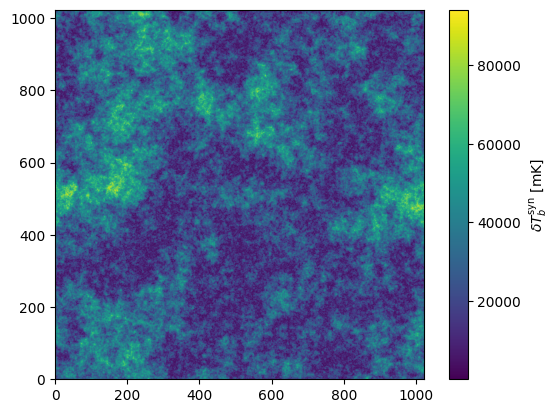

(None, None)

<Figure size 640x480 with 0 Axes>

In [4]:
L_box = 2048 * u.Mpc
N_pix = 1024
random_seed = 918

# define redshift and corresponding observed frequency
i_channel = 600
z = redshifts[i_channel]
freq = freqs[i_channel]
print(' channels id %d :   z = %.3f   freq = %.2f %s' %(i_channel, z, freq.value, freq.unit))

# galactic foreground syncrotron emeission model
dT = t2c.galactic_synch_fg(z=z, ncells=N_pix, boxsize=L_box.value, rseed=random_seed) * u.mK

plt.imshow(dT.value, origin='lower')
plt.colorbar(label=r'$\delta T^\mathrm{syn}_b$ [%s]' %dT.unit)
plt.show(), plt.clf()

## Eart Location

In [22]:
# select SKA-Low central location
loc = EarthLocation(lon=116.7644482*u.deg, lat=-26.82472208*u.deg)

# check the coordinates in the sky that are above the select location (local time)
tobs_star = Time('2021-09-21T14:12:40.1', scale='utc', location=loc) # like in the SDC3a data challenge
tobs_end = Time('2021-09-21T18:12:40.1', scale='utc', location=loc) # 4 hour daily observation

# get coordinates in the sky at this locations
sc_star = SkyCoord(ra=tobs_star.sidereal_time('apparent'), dec=loc.lat)
ra_star, dec_star = sc_star.ra.deg, sc_star.dec.deg
print(tobs_star, ':\t', 'RA = %.3f\tDEC = %.3f' %(ra_star, dec_star))

sc_end = SkyCoord(ra=tobs_end.sidereal_time('apparent'), dec=loc.lat)
ra_end, dec_star = sc_end.ra.deg, sc_end.dec.deg
print(tobs_end, ':\t', 'RA = %.3f\tDEC = %.3f' %(ra_end, dec_star))

# select the pointing of telescope (need to be between the RA at begin and end)
ra, dec = 0., -30.
print('\nSelected SKA-Low pointing:\t', 'RA = %.3f\tDEC = %.3f' %(ra, dec))

2021-09-21T14:12:40.100 :	 RA = 330.605	DEC = -26.825
2021-09-21T18:12:40.100 :	 RA = 30.769	DEC = -26.825

Selected SKA-Low pointing:	 RA = 0.000	DEC = -30.000


## Angular quantities for the lmn coordinates

In [8]:
# angular resolution in rad
dthet = L_box / ((1+z)*cosmo.angular_diameter_distance(z)*N_pix) * u.rad
print('angular resolution of the input image:', dthet.to('arcsec'))

# field of view
FoV = (dthet*N_pix).to('deg')
print('FoV: %.3f %s' %(FoV.value, FoV.unit))

# pixel area
pixel_area = (dthet*dthet).to('sr')

print('pixel area:', pixel_area)
print('solid angle:', pixel_area*N_pix)

angular resolution of the input image: 45.856870871937055 arcsec
FoV: 13.044 deg
pixel area: 4.942635301557817e-08 sr
solid angle: 5.061258548795205e-05 sr


## Convert Kelvin to Jensky
see description for more info: https://science.nrao.edu/facilities/vla/proposing/TBconv

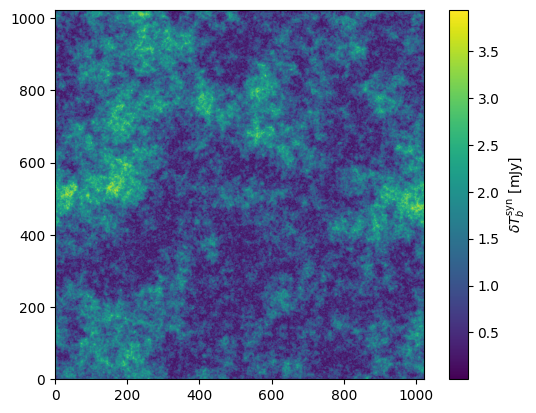

(None, None)

<Figure size 640x480 with 0 Axes>

In [9]:
# equivalence to convert temperature (mK) to brightness (Jy)
equiv_jy2k = u.brightness_temperature(frequency=freq, beam_area=pixel_area)

# sky model in Jy units
dT_jy = dT.to('Jy', equivalencies=equiv_jy2k)

plt.imshow(dT_jy.to('mJy').value, origin='lower')
plt.colorbar(label=r'$\delta T^\mathrm{syn}_b$ [mJy]')
plt.show(), plt.clf()

## Create fits file

In [24]:
path_out = './'

print('%d: z=%.3f   %.2f %s' %(i_channel, z, freq.value, freq.unit))
print('dT : min=%.3f   mean=%.3f   max=%.3f %s' %(dT.value.min(), dT.value.mean(), dT.value.max(), dT.unit))
print('dT_jy : min=%.3f   mean=%.3f   max=%.3f %s' %((dT_jy.value.min(), dT_jy.value.mean(), dT_jy.value.max(), dT_jy.unit)))

# crete a fits image
hdu = fits.PrimaryHDU(dT_jy.value)
hdul = fits.HDUList([hdu])
hdul[0].header.set('TELESCOP', 'SKA1-Low')
hdul[0].header.set('CTYPE1', 'RA---SIN')
hdul[0].header.set('CTYPE2', 'DEC--SIN')
hdul[0].header.set('BMAJ', dthet.value)
hdul[0].header.set('BMIN', dthet.value)
hdul[0].header.set('ORIGIN', 'tools21cm')
hdul[0].header.set('BUNIT', 'Jy')
hdul[0].header.set('BTYPE', 'Intensity')
hdul[0].header.set('HISTORY', 'Galactic syncrothon emission created with tools21cm')
hdul[0].header.set('CTYPE1', 'RA')
hdul[0].header.set('CRPIX1', N_pix//2)
hdul[0].header.set('CRVAL1', ra)
hdul[0].header.set('CDELT1', -dthet.to('deg').value)
hdul[0].header.set('CUNIT1', 'deg')
hdul[0].header.set('CTYPE2', 'DEC')
hdul[0].header.set('CRPIX2', N_pix//2)
hdul[0].header.set('CRVAL2', dec)
hdul[0].header.set('CDELT2', dthet.to('deg').value)
hdul[0].header.set('CUNIT2', 'deg')
hdul[0].header.set('CTYPE3', 'FREQ')
hdul[0].header.set('CRPIX3', 1)
hdul[0].header.set('CRVAL3', freq.to('Hz').value)
hdul[0].header.set('CDELT3', dfreq.to('Hz').value)
hdul[0].header.set('CUNIT3', 'Hz')
hdul[0].header.set('CTYPE4', 'STOKES')
hdul[0].header.set('CRPIX4', 1)
hdul[0].header.set('CRVAL4', 1)
hdul[0].header.set('CDELT4', 1)
hdul[0].header.set('CUNIT4', '')
hdul[0].header.set('DATE-OBS', tobs_star.to_string())

hdul = fits.HDUList([hdu])
hdul.writeto(path_out+'syngf_ch%d_%d.fits' %(i_channel, N_pix), overwrite=True)

600: z=7.554   166.00 MHz
dT : min=28.835   mean=26294.114   max=94153.889 mK
dT_jy : min=0.000   mean=0.001   max=0.004 Jy


## Read fits files

(None, None)

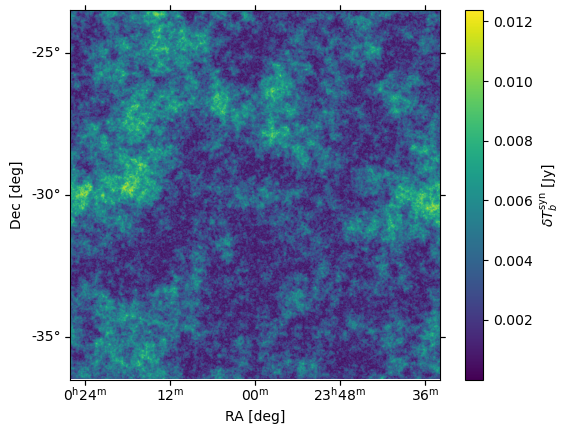

In [96]:
from astropy.io import fits
from astropy.wcs import WCS
import astropy.coordinates as coord

data, header = fits.getdata(path_out+'syngf_ch%d_%d.fits' %(i_channel, N_pix), header=True)
w = WCS(header)

ax = plt.subplot(projection=w.celestial)
im = ax.imshow(data)
plt.colorbar(im, ax=ax, label=r'$\delta T^\mathrm{syn}_b$ [Jy]')
ax.set_xlabel('RA [deg]'), ax.set_ylabel('Dec [deg]')

In [ ]:
#WCS = WCS.celestial
N_1, N_2 = w.celestial.array_shape
idx_1 = np.arange(1, N_1 + 1).reshape(N_1, 1)
idx_2 = np.arange(1, N_2 + 1).reshape(1, N_2)

d_1, d_2 = w.celestial.all_pix2world(idx_1, idx_2, 1)  # [deg]
if w.wcs.lng == 0:
    lon, lat = d_1, d_2
else:
    lat, lon = d_1, d_2

sky_coord = np.vstack((lon[np.newaxis, ...], lat[np.newaxis, ...])).reshape(2, N_1*N_2)